## Investigation on how dataset and transfer learning affect neural network effectiveness on the example of speech recognition

Alicja Krzemińska akrzeminska1519@gmail.com  
Szymon Auguścik szyauguscik@gmail.com

### Investigated fators:  
- training set size
- transfer learning
- augumentation

### Imports, downloading data

In [1]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

from typing import Callable, List

warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Alicja
#!unzip '/content/gdrive/MyDrive/Colab Notebooks/IO_project3_data.zip'
# Szymon
!unzip '/content/gdrive/MyDrive/Colab Notebooks/Inteligencja Obliczeniowa/Projekt3/IO_project3_data.zip'

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: IO_project3_data/four/a1533da4_nohash_1.wav  
  inflating: IO_project3_data/four/a1c63f25_nohash_0.wav  
  inflating: IO_project3_data/four/a1cff772_nohash_0.wav  
  inflating: IO_project3_data/four/a1cff772_nohash_1.wav  
  inflating: IO_project3_data/four/a1cff772_nohash_2.wav  
  inflating: IO_project3_data/four/a1cff772_nohash_3.wav  
  inflating: IO_project3_data/four/a1cff772_nohash_4.wav  
  inflating: IO_project3_data/four/a1dd919f_nohash_0.wav  
  inflating: IO_project3_data/four/a243fcc2_nohash_0.wav  
  inflating: IO_project3_data/four/a243fcc2_nohash_1.wav  
  inflating: IO_project3_data/four/a24cf51c_nohash_0.wav  
  inflating: IO_project3_data/four/a24cf51c_nohash_1.wav  
  inflating: IO_project3_data/four/a2b16113_nohash_0.wav  
  inflating: IO_project3_data/four/a2b16113_nohash_1.wav  
  inflating: IO_project3_data/four/a3255f5c_nohash_0.wav  
  inflating: IO_project3_data/four/a331d9cb_nohash

In [4]:
labels_training_set_size = ['bed', 'bird', 'cat', 'dog', 'down']
labels_transfer_learning = ['eight', 'five', 'four', 'go', 'happy']
train_audio_path = 'IO_project3_data'

### Training on the datasets for different sizes of sets

#### Data preprocessing

In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def add_noise(data: np.array, noise_factor: float) -> np.array:
  """
  Function creates random noise and adds it to existing audio data
  """
  noise = np.random.randn(len(data))
  augmented_data = data + noise_factor * noise
  augmented_data = augmented_data.astype(type(data[0]))

  return augmented_data

def change_pitch(data: np.array, sampling_rate: int, pitch_factor: float) -> np.array:
  """
  Function manipulates the pitch of an audio data
  """
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def resample_waves_and_split_datasets(labels: List, path: str, augmentation: bool = False) -> (np.array, np.array, 
                                                                                              np.array, np.array):
  """
  Function searches files from given path in order to find directories of
  names given in labels 
  """
  all_waves = []
  all_labels = []

  for label in labels:
      print(label)
      waves = [f for f in os.listdir(path + '/'+ label) if f.endswith('.wav')]

      for wav in waves:
          samples, sample_rate = librosa.load(path + '/' + label + '/' + wav, sr = 16000)
          samples = librosa.resample(samples, sample_rate, 8000)

          if (len(samples) == 8000):
              all_waves.append(samples)
              all_labels.append(label)
              
  if augmentation:
    noise_factor1 = 0.001
    noise_factor2 = 0.005
    sampling_rate = 8000
    pitch_factor1 = -0.3
    pitch_factor2 = 0.3

    noise_waves1 = [add_noise(wave, noise_factor1) for wave in all_waves]
    noise_waves2 = [add_noise(wave, noise_factor2) for wave in all_waves]
    pitch_waves1 = [change_pitch(wave, sampling_rate, pitch_factor1) for wave in all_waves]
    pitch_waves2 = [change_pitch(wave, sampling_rate, pitch_factor2) for wave in all_waves]

    all_waves = all_waves + noise_waves1 + noise_waves2 + pitch_waves1 + pitch_waves2
    all_labels = 5 * all_labels

    all_waves, all_labels = shuffle(all_waves, all_labels)

  le = LabelEncoder()
  y = le.fit_transform(all_labels)
  y = np_utils.to_categorical(y, num_classes=len(labels_training_set_size))

  return train_test_split(np.array(all_waves), np.array(y), stratify=y, 
                                            test_size = 0.2, random_state=777, shuffle=True)

In [ ]:
x_tr, x_val, y_tr, y_val = resample_waves_and_split_datasets(labels_training_set_size, train_audio_path)

bed
bird
cat
dog
down


In [7]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import metrics
from keras import backend as K
K.clear_session()

def create_model() -> Model:
  """
  Function creates neural network to analyse audio data
  """
  inputs = Input(shape=(8000,1))

  #First Conv1D layer
  conv = Conv1D(8, 13, padding='valid', activation='relu', strides=1)(inputs)
  conv = MaxPooling1D(3)(conv)
  conv = Dropout(0.3)(conv)

  #Second Conv1D layer
  conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
  conv = MaxPooling1D(3)(conv)
  conv = Dropout(0.3)(conv)

  #Third Conv1D layer
  conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
  conv = MaxPooling1D(3)(conv)
  conv = Dropout(0.3)(conv)

  #Fourth Conv1D layer
  conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
  conv = MaxPooling1D(3)(conv)
  conv = Dropout(0.3)(conv)

  #Flatten layer
  conv = Flatten()(conv)

  #Dense Layer 1
  conv = Dense(256, activation='relu')(conv)
  conv = Dropout(0.3)(conv)

  #Dense Layer 2
  conv = Dense(128, activation='relu')(conv)
  conv = Dropout(0.3)(conv)

  outputs = Dense(len(labels_training_set_size), activation='softmax')(conv)
  model = Model(inputs, outputs)

  return model

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def train_model_for_n_samples(n: int, x_tr: np.array, y_tr: np.array, x_val: np.array, y_val: np.array, 
                              labels: List, ready_model: Model = None):
  """
  Function trains given model (when no model was passed, it creates one itself) with a dataset of size equls n, 
  extracted from x_tr and y_tr, then validates its performance based on x_val and y_val. It also returns 
  reporting structures (accuracy, confusion matrix and classification report) after training process.
  """
  print(f"Training for {n} samples...")
  x_tr_n = x_tr[:n]
  y_tr_n = y_tr[:n]

  model_file_name = f'best_model_{n}.hdf5' if ready_model == None else f'best_model.hdf5'

  if ready_model == None:
    ready_model = create_model()

    ready_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
    # ready_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
  mc_n = ModelCheckpoint(model_file_name, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

  history = ready_model.fit(x_tr_n, y_tr_n, epochs=10, callbacks=[es, mc_n], batch_size=32, validation_data=(x_val,y_val))
  y_pred = np.argmax(ready_model.predict(x_val), axis=1)
  y_test = np.argmax(y_val, axis=1)

  accuracy = history.history['accuracy'][-1]
  val_accuracy = history.history['val_accuracy'][-1]
  auc = history.history['auc'][-1]
  cm = confusion_matrix(y_test, y_pred)
  report = classification_report(y_test, y_pred, target_names=labels)
  
  return accuracy, val_accuracy, auc, cm, report

In [ ]:
datasize_range = range(500, x_tr.shape[0], 500) # x_tr.shape[0]
results = np.transpose([train_model_for_n_samples(n, x_tr, y_tr, x_val, y_val, labels_training_set_size) for n in datasize_range])

accuracies = results[0, :]
val_accuracies = results[1, :]
aucs = results[2, :]
matrices = results[3, :]
reports = results[4, :]

Training for 500 samples...
Epoch 1/10
16/16 [==============================] - 9s 471ms/step - loss: 1.6088 - accuracy: 0.2625 - auc: 0.5327 - val_loss: 1.5991 - val_accuracy: 0.2622 - val_auc: 0.5499

Epoch 00001: accuracy improved from -inf to 0.27600, saving model to best_model_500.hdf5
Epoch 2/10
16/16 [==============================] - 7s 422ms/step - loss: 1.5791 - accuracy: 0.2782 - auc: 0.5815 - val_loss: 1.5977 - val_accuracy: 0.2622 - val_auc: 0.5547

Epoch 00002: accuracy improved from 0.27600 to 0.28400, saving model to best_model_500.hdf5
Epoch 3/10
16/16 [==============================] - 7s 420ms/step - loss: 1.5667 - accuracy: 0.2903 - auc: 0.6105 - val_loss: 1.5950 - val_accuracy: 0.2792 - val_auc: 0.5559

Epoch 00003: accuracy improved from 0.28400 to 0.28800, saving model to best_model_500.hdf5
Epoch 4/10
16/16 [==============================] - 6s 417ms/step - loss: 1.5337 - accuracy: 0.3460 - auc: 0.6462 - val_loss: 1.5983 - val_accuracy: 0.2646 - val_auc: 0.5519


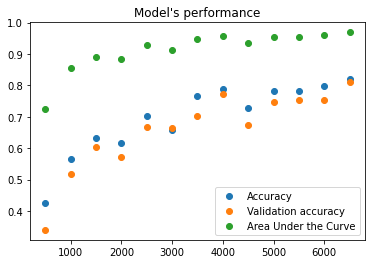

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_metrics_for_n_samples(size_range: Callable, metrics: List, legend: List):
  """
  Functions plots metrics achieved by neural network in training with n samples
  """
  for i in range(len(metrics)):
    plt.scatter(size_range, metrics[i], label=legend[i]) 
    
  plt.title("Model's performance")
  plt.legend()
  plt.show()

metrics = [accuracies, val_accuracies, aucs]
legend_list = ['Accuracy', 'Validation accuracy', 'Area Under the Curve']
plot_metrics_for_n_samples(datasize_range, metrics, legend_list)

Report for dataset size = 500
              precision    recall  f1-score   support

         bed       0.27      0.15      0.20       297
        bird       0.51      0.13      0.21       304
         cat       0.28      0.92      0.43       303
         dog       0.12      0.01      0.01       309
        down       0.51      0.44      0.48       431

    accuracy                           0.34      1644
   macro avg       0.34      0.33      0.26      1644
weighted avg       0.35      0.34      0.28      1644



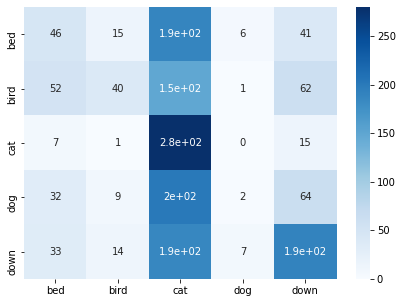

Report for dataset size = 1000
              precision    recall  f1-score   support

         bed       0.38      0.22      0.28       297
        bird       0.56      0.65      0.60       304
         cat       0.40      0.93      0.56       303
         dog       0.73      0.44      0.55       309
        down       0.74      0.39      0.51       431

    accuracy                           0.52      1644
   macro avg       0.56      0.53      0.50      1644
weighted avg       0.58      0.52      0.50      1644



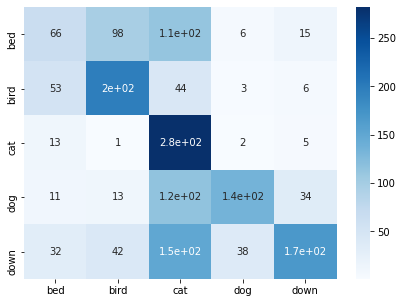

Report for dataset size = 1500
              precision    recall  f1-score   support

         bed       0.46      0.39      0.42       297
        bird       0.69      0.55      0.61       304
         cat       0.52      0.93      0.67       303
         dog       0.70      0.53      0.61       309
        down       0.71      0.62      0.66       431

    accuracy                           0.61      1644
   macro avg       0.62      0.60      0.59      1644
weighted avg       0.62      0.61      0.60      1644



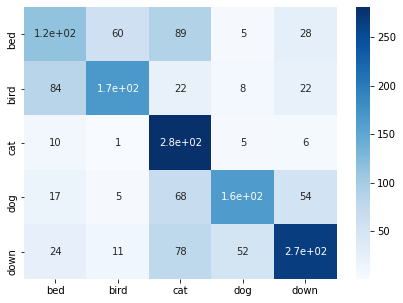

Report for dataset size = 2000
              precision    recall  f1-score   support

         bed       0.51      0.47      0.49       297
        bird       0.76      0.79      0.77       304
         cat       0.47      0.92      0.62       303
         dog       0.51      0.25      0.33       309
        down       0.66      0.48      0.55       431

    accuracy                           0.57      1644
   macro avg       0.58      0.58      0.55      1644
weighted avg       0.59      0.57      0.55      1644



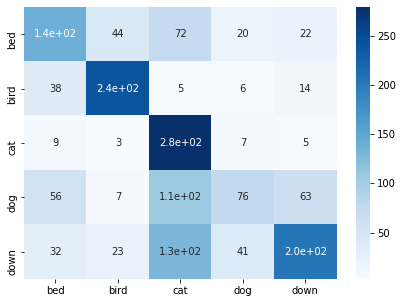

Report for dataset size = 2500
              precision    recall  f1-score   support

         bed       0.55      0.39      0.46       297
        bird       0.64      0.77      0.70       304
         cat       0.60      0.92      0.73       303
         dog       0.88      0.53      0.66       309
        down       0.72      0.72      0.72       431

    accuracy                           0.67      1644
   macro avg       0.68      0.66      0.65      1644
weighted avg       0.68      0.67      0.66      1644



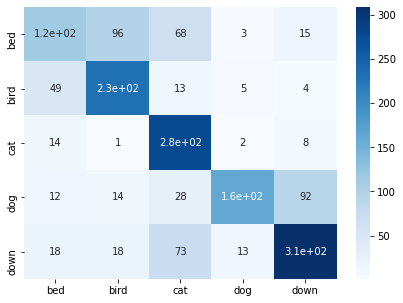

Report for dataset size = 3000
              precision    recall  f1-score   support

         bed       0.47      0.67      0.56       297
        bird       0.79      0.63      0.70       304
         cat       0.55      0.48      0.51       303
         dog       0.83      0.64      0.72       309
        down       0.75      0.83      0.79       431

    accuracy                           0.66      1644
   macro avg       0.68      0.65      0.66      1644
weighted avg       0.69      0.66      0.67      1644



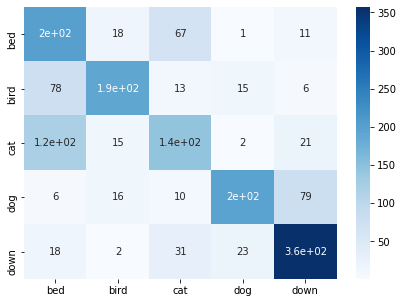

Report for dataset size = 3500
              precision    recall  f1-score   support

         bed       0.55      0.74      0.63       297
        bird       0.85      0.71      0.77       304
         cat       0.73      0.89      0.80       303
         dog       0.93      0.35      0.51       309
        down       0.68      0.80      0.73       431

    accuracy                           0.70      1644
   macro avg       0.75      0.70      0.69      1644
weighted avg       0.74      0.70      0.69      1644



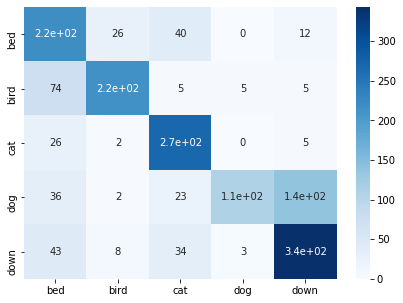

Report for dataset size = 4000
              precision    recall  f1-score   support

         bed       0.66      0.60      0.63       297
        bird       0.78      0.86      0.82       304
         cat       0.77      0.87      0.82       303
         dog       0.72      0.86      0.78       309
        down       0.93      0.70      0.80       431

    accuracy                           0.77      1644
   macro avg       0.77      0.78      0.77      1644
weighted avg       0.78      0.77      0.77      1644



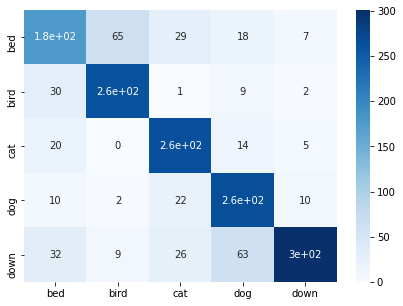

Report for dataset size = 4500
              precision    recall  f1-score   support

         bed       0.52      0.71      0.60       297
        bird       0.85      0.73      0.79       304
         cat       0.64      0.89      0.74       303
         dog       0.65      0.43      0.52       309
        down       0.80      0.63      0.71       431

    accuracy                           0.68      1644
   macro avg       0.69      0.68      0.67      1644
weighted avg       0.70      0.68      0.67      1644



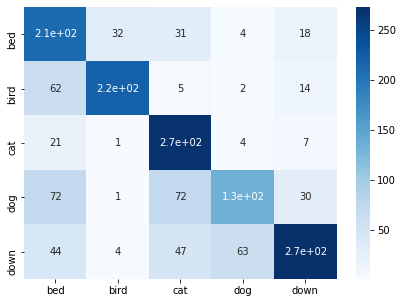

Report for dataset size = 5000
              precision    recall  f1-score   support

         bed       0.72      0.48      0.58       297
        bird       0.77      0.86      0.81       304
         cat       0.61      0.97      0.75       303
         dog       0.89      0.62      0.73       309
        down       0.83      0.79      0.81       431

    accuracy                           0.75      1644
   macro avg       0.76      0.74      0.74      1644
weighted avg       0.77      0.75      0.74      1644



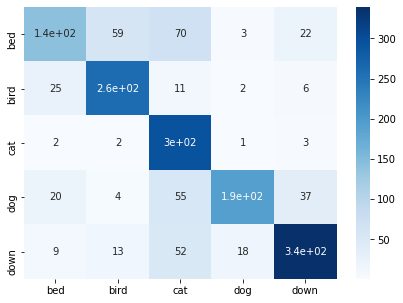

Report for dataset size = 5500
              precision    recall  f1-score   support

         bed       0.86      0.61      0.71       297
        bird       0.91      0.82      0.86       304
         cat       0.65      0.94      0.77       303
         dog       0.70      0.67      0.68       309
        down       0.74      0.74      0.74       431

    accuracy                           0.75      1644
   macro avg       0.77      0.75      0.75      1644
weighted avg       0.77      0.75      0.75      1644



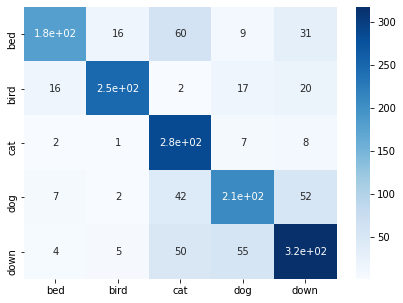

Report for dataset size = 6000
              precision    recall  f1-score   support

         bed       0.62      0.74      0.68       297
        bird       0.95      0.65      0.77       304
         cat       0.70      0.91      0.79       303
         dog       0.75      0.76      0.76       309
        down       0.84      0.72      0.77       431

    accuracy                           0.75      1644
   macro avg       0.77      0.76      0.75      1644
weighted avg       0.78      0.75      0.75      1644



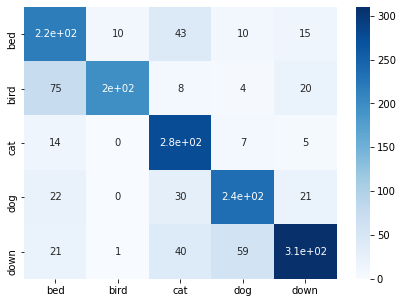

Report for dataset size = 6500
              precision    recall  f1-score   support

         bed       0.73      0.72      0.72       297
        bird       0.70      0.93      0.80       304
         cat       0.94      0.73      0.82       303
         dog       0.93      0.76      0.84       309
        down       0.82      0.88      0.85       431

    accuracy                           0.81      1644
   macro avg       0.82      0.80      0.81      1644
weighted avg       0.82      0.81      0.81      1644



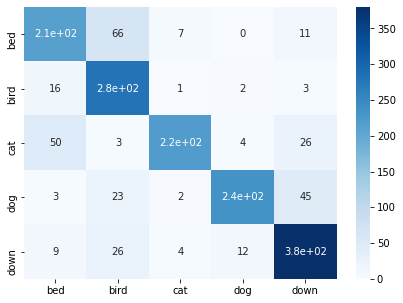

In [ ]:
from seaborn import heatmap
from pandas import DataFrame

def plot_conf_matrix(confusion_matrix: np.array, labels: List):
  """
  Function beautifies the visualisation of confusion matrix without passing estimator
  """
  df_cm = DataFrame(confusion_matrix, index = labels, columns = labels)
  plt.figure(figsize = (7, 5))
  heatmap(df_cm, annot=True, cmap='Blues')
  plt.show()

def report_training(datasize_range: Callable, matrices: np.array, reports: np.array, labels: List):
  """
  Function generates summarized report (confusion matrix, classification report)
  for every datasize given in datasize_range
  """
  for i in range(0, len(reports)):
    print(f"Report for dataset size = {datasize_range[i]}")
    print(reports[i])
    plot_conf_matrix(matrices[i], labels) 

report_training(datasize_range, matrices, reports, labels_training_set_size)

### Transfer Learning

#### A - Freezing 

In [ ]:
def get_dataset_size_at_nearest_accuracy(datasize_range: Callable, given_accuracy: float, 
                                         achieved_accuracies: List) -> int: 
  """
  This function returns the size of dataset that achieved a score which is
  the nearest to given_accuracy.

  Steps:
  1. Calculate absolute norm between given_accuracy and every achieved accuracy
  2. Get index of the nearest accuracy
  3. Return size from datasize_range at that index
  """

  norm_accuracies = np.abs(achieved_accuracies - given_accuracy)
  nearest_index = np.argmin(norm_accuracies)

  return datasize_range[nearest_index]

In [9]:
x_tr, x_val, y_tr, y_val = resample_waves_and_split_datasets(labels_transfer_learning, train_audio_path)

eight
five
four
go
happy


In [ ]:
from keras.models import load_model

best_accuracy = 1
chosen_accuracy = 0.65

best_size = get_dataset_size_at_nearest_accuracy(datasize_range, best_accuracy, accuracies)
chosen_size = get_dataset_size_at_nearest_accuracy(datasize_range, chosen_accuracy, accuracies)
model_file_name = f"best_model_{best_size}.hdf5"
freezed_model = load_model(model_file_name)

print(f"Size of the best accuracy = {best_size}")

for layer in freezed_model.layers:
  if layer.__class__.__name__ == 'Conv1D':
    layer.trainable = False

transfer_accuracy, transfer_val_accuracy, transfer_auc, transfer_cm, transfer_report = train_model_for_n_samples(chosen_size, 
                                                                                                    x_tr, y_tr, x_val, y_val, 
                                                                                          labels_transfer_learning, freezed_model)

Size of the best accuracy = 6500
Training for 3000 samples...
Epoch 1/10
94/94 [==============================] - 25s 265ms/step - loss: 1.4338 - accuracy: 0.3913 - auc: 0.7279 - val_loss: 1.1310 - val_accuracy: 0.5298 - val_auc: 0.8366

Epoch 00001: accuracy improved from -inf to 0.39133, saving model to best_model.hdf5
Epoch 2/10
94/94 [==============================] - 24s 260ms/step - loss: 0.9584 - accuracy: 0.6170 - auc: 0.8861 - val_loss: 0.7863 - val_accuracy: 0.7044 - val_auc: 0.9226

Epoch 00002: accuracy improved from 0.39133 to 0.61700, saving model to best_model.hdf5
Epoch 3/10
94/94 [==============================] - 25s 262ms/step - loss: 0.6745 - accuracy: 0.7347 - auc: 0.9422 - val_loss: 0.5494 - val_accuracy: 0.7971 - val_auc: 0.9614

Epoch 00003: accuracy improved from 0.61700 to 0.73467, saving model to best_model.hdf5
Epoch 4/10
94/94 [==============================] - 25s 262ms/step - loss: 0.5608 - accuracy: 0.7883 - auc: 0.9600 - val_loss: 0.5195 - val_accuracy:

Achieved accuracy with transfer learning = 0.8943333625793457
Achieved validation accuracy with transfer learning = 0.901289701461792
Achieved AUC with transfer learning = 0.9886946082115173
Report for dataset size = 3000
              precision    recall  f1-score   support

       eight       0.87      0.99      0.92       422
        five       0.97      0.87      0.91       432
        four       0.85      0.93      0.89       432
          go       0.92      0.82      0.87       420
       happy       0.93      0.89      0.91       310

    accuracy                           0.90      2016
   macro avg       0.91      0.90      0.90      2016
weighted avg       0.91      0.90      0.90      2016



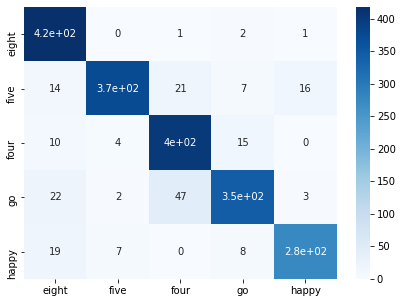

In [ ]:
print(f"Achieved accuracy with transfer learning = {transfer_accuracy}")
print(f"Achieved validation accuracy with transfer learning = {transfer_val_accuracy}")
print(f"Achieved AUC with transfer learning = {transfer_auc}")
report_training([chosen_size], [transfer_cm], [transfer_report], labels_transfer_learning)

#### B - SVM

In [ ]:
indirect_model = load_model(model_file_name)
conv_layer = [layer for layer in indirect_model.layers if layer.__class__.__name__ == 'Conv1D'][-1]

# in order to get proper X_train size, one should extract more features than chosen_size
# and then split them into two groups with selected coefficient
train_size = 0.8
chosen_size = 1000

extract = Model(indirect_model.inputs, conv_layer.output)
X = extract.predict(x_tr[: int(chosen_size / train_size)])
y = np.argmax(y_tr[: int(chosen_size / train_size)], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=421)
X_train, X_test = X_train.reshape(X_train.shape[0], -1), X_test.reshape(X_test.shape[0], -1)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

params = {
    'C': [0.2, 0.5, 1, 5, 10],
    'kernel': ['linear', 'rbf', 'sigmoid']
}

svm_gcv_model = GridSearchCV(SVC(), params, scoring='accuracy')
svm_gcv_model.fit(X_train, y_train)

y_pred = svm_gcv_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=labels_transfer_learning)

Achieved accuracy with transfer learning = 0.6980000000000001
Report for dataset size = 1000
              precision    recall  f1-score   support

       eight       0.71      0.89      0.79        55
        five       0.91      0.76      0.83        54
        four       0.62      0.69      0.65        51
          go       0.68      0.53      0.60        64
       happy       0.70      0.81      0.75        26

    accuracy                           0.72       250
   macro avg       0.73      0.74      0.72       250
weighted avg       0.73      0.72      0.72       250



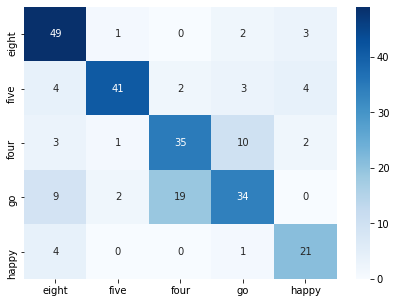

In [ ]:
print(f"Achieved accuracy with transfer learning = {svm_gcv_model.best_score_}")
report_training([chosen_size], [cm], [report], labels_transfer_learning)

#### Data augmentation

##### Without augmentation

In [18]:
chosen_size = 1000

x_tr, x_val, y_tr, y_val = resample_waves_and_split_datasets(labels_transfer_learning, train_audio_path)

no_aug_accuracy, no_aug_val_accuracy, no_aug_auc, no_aug_cm, no_aug_report = train_model_for_n_samples(chosen_size, x_tr, y_tr, x_val, y_val, 
                                                                                                       labels_transfer_learning)

eight
five
four
go
happy
Training for 1000 samples...
Epoch 1/10
32/32 [==============================] - 9s 263ms/step - loss: 1.5975 - accuracy: 0.2254 - auc: 0.5343 - val_loss: 1.5797 - val_accuracy: 0.2336 - val_auc: 0.5752

Epoch 00001: accuracy improved from -inf to 0.23700, saving model to best_model_1000.hdf5
Epoch 2/10
32/32 [==============================] - 8s 252ms/step - loss: 1.5472 - accuracy: 0.2741 - auc: 0.6133 - val_loss: 1.5448 - val_accuracy: 0.2723 - val_auc: 0.6159

Epoch 00002: accuracy improved from 0.23700 to 0.27400, saving model to best_model_1000.hdf5
Epoch 3/10
32/32 [==============================] - 8s 252ms/step - loss: 1.5005 - accuracy: 0.2960 - auc: 0.6465 - val_loss: 1.4603 - val_accuracy: 0.3482 - val_auc: 0.6758

Epoch 00003: accuracy improved from 0.27400 to 0.31800, saving model to best_model_1000.hdf5
Epoch 4/10
32/32 [==============================] - 8s 252ms/step - loss: 1.3550 - accuracy: 0.4088 - auc: 0.7478 - val_loss: 1.3866 - val_accura

Accuracy without augmentation = 0.6349999904632568
Validation accuracy without augmentation = 0.5704365372657776
AUC without augmentation = 0.9027022123336792
Report for dataset size = 1000
              precision    recall  f1-score   support

       eight       0.54      0.95      0.69       422
        five       0.76      0.41      0.53       432
        four       0.72      0.43      0.54       432
          go       0.49      0.40      0.44       420
       happy       0.49      0.71      0.58       310

    accuracy                           0.57      2016
   macro avg       0.60      0.58      0.56      2016
weighted avg       0.61      0.57      0.55      2016



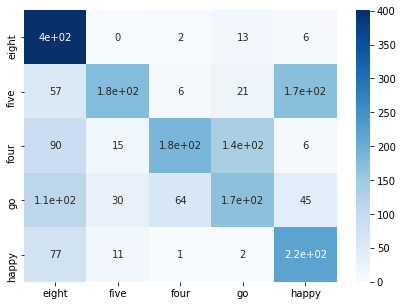

In [19]:
print(f"Accuracy without augmentation = {no_aug_accuracy}")
print(f"Validation accuracy without augmentation = {no_aug_val_accuracy}")
print(f"AUC without augmentation = {no_aug_auc}")
report_training([chosen_size], [no_aug_cm], [no_aug_report], labels_transfer_learning)

##### With augmentation

In [20]:
x_tr, x_val, y_tr, y_val = resample_waves_and_split_datasets(labels_transfer_learning, train_audio_path, augmentation = True)

# we increase the dataset size four times by adding 4 new sets: 2 with noise and 2 with changed pitch
chosen_size = 5000

aug_accuracy, aug_val_accuracy, aug_auc, aug_cm, aug_report = train_model_for_n_samples(chosen_size, x_tr, y_tr, x_val, y_val, 
                                                                                        labels_transfer_learning)

eight
five
four
go
happy
Training for 5000 samples...
Epoch 1/10
157/157 [==============================] - 41s 253ms/step - loss: 1.5797 - accuracy: 0.2502 - auc: 0.5798 - val_loss: 1.4170 - val_accuracy: 0.3583 - val_auc: 0.7304

Epoch 00001: accuracy improved from -inf to 0.28040, saving model to best_model_5000.hdf5
Epoch 2/10
157/157 [==============================] - 39s 252ms/step - loss: 1.3398 - accuracy: 0.4047 - auc: 0.7559 - val_loss: 1.0562 - val_accuracy: 0.5624 - val_auc: 0.8604

Epoch 00002: accuracy improved from 0.28040 to 0.46220, saving model to best_model_5000.hdf5
Epoch 3/10
157/157 [==============================] - 40s 253ms/step - loss: 1.0019 - accuracy: 0.5995 - auc: 0.8726 - val_loss: 0.9518 - val_accuracy: 0.6058 - val_auc: 0.8832

Epoch 00003: accuracy improved from 0.46220 to 0.59960, saving model to best_model_5000.hdf5
Epoch 4/10
157/157 [==============================] - 40s 253ms/step - loss: 0.8099 - accuracy: 0.6672 - auc: 0.9162 - val_loss: 0.7142 

Accuracy with augmentation = 0.829800009727478
Validation accuracy with augmentation = 0.8223214149475098
AUC with augmentation = 0.9742626547813416
Report for dataset size = 5000
              precision    recall  f1-score   support

       eight       0.83      0.96      0.89      2111
        five       0.83      0.85      0.84      2161
        four       0.91      0.66      0.77      2158
          go       0.73      0.77      0.75      2101
       happy       0.83      0.90      0.86      1549

    accuracy                           0.82     10080
   macro avg       0.83      0.83      0.82     10080
weighted avg       0.83      0.82      0.82     10080



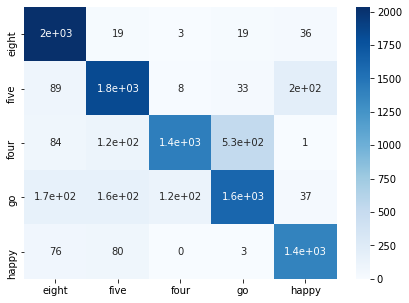

In [21]:
print(f"Accuracy with augmentation = {aug_accuracy}")
print(f"Validation accuracy with augmentation = {aug_val_accuracy}")
print(f"AUC with augmentation = {aug_auc}")
report_training([chosen_size], [aug_cm], [aug_report], labels_transfer_learning)

##### Examples of data augmentation

1. Normal voice
2. Small noise
3. Noticable noise
4. Lower pitch
5. Higher pitch

In [ ]:
no = 7
ipd.Audio(x_tr[no], rate=8000)

In [ ]:
ipd.Audio(x_tr[no + 50], rate=8000)

In [ ]:
ipd.Audio(x_tr[no + 100], rate=8000)

In [ ]:
ipd.Audio(x_tr[no + 150], rate=8000)

In [ ]:
ipd.Audio(x_tr[no + 200], rate=8000)

#### Summary

In this notebook we consider the impact of three factors (dataset size, transfer learning, data augmentation) on the neural network model effectiveness on the example of speech recognition.
1. **Dataset size**
 
 Having a graph of accuracy versus size of the data set (presented in the "Training on the datasets for different sizes of sets" section) we can notice that (in general) the bigger dataset, the better accuracy. In addition, the difference between training accuracy and cross validation score tends to decrease with respect to increasing dataset size, thus preventing model from high variance. More data generalizes the model (similar accuracy for train and validation dataset) and leads to higher effectiveness e.g. for a model trained on 500 samples both a validation accuracy and an accuracy for the training set are low but accuracies for dataset containing 4000 samples reach about 80%. 
 
 
2. **Transfer learning**
 
 Transfer learning is a method to use when only a small training dataset is available. In such situation there can be used a pretrained model (trained on another dataset but with data in the same form e.g. model pretrained on a set of waves can be used to transfer learning on another waves) or one can extract features from neural submodel and use them to train another machine learning algorithm such as SVM. 
 
  We research two approaches:
 * Freezing - in this case we use a model trained in previous exercise (6500 samples) and a new dataset with 3000 samples (the closest accuracy to 65%). By freezing convolutional layers and training only dense layers, we achieved accuracy equal 89%. Having results from previous exercise we can suppose that accuracy for the training on dataset in this size from scratch is about 65%. We consider it as a huge increase.
 * SVM for features extracted by neural network - in this case we achieved accuracy below 60%. To train SVM models we split the set of features and use just 0.8 of them in order to get appropiate size of train set (1000 in this case) - the rest becomes validation set. The score achieved by SVM (just below 70%) is far better than accuracy from first try. 

  In summary, transfer learning enables a model with a high score despite a small dataset.
 
3. **Data augmentation**
 
 Data augmentation is another way to reach high effectiveness by having a small dataset. Augmentation extends the number of samples in the dataset by adding some noise to the sample or by changing it slightly in another way. Augmentation type depends on type of data (waves, pictures, words) and particular use cases. 
 In our case (waves) we use noise with different intensities and waves with changed pitch and make an experiment with dataset size equal 1000. 
 Accuracy without augmentation for 1000 samples is 63% and with augmentation for 5000 samples - 83%. The augmentation score seems to be reasonable due to phenomenon showed earlier - the more data, the better performance. In addition, gap between training and cross validation scores decreased significantly. But there is an interesting fact connected with size of augmented data, too. After adding some synthetic samples, model managed to achieve similar result to dataset from first exercise. It can be explained by a conclusion that augmentation is comparable with gathering new data.